In [3]:
import os
import cv2
import argparse
import librosa
import numpy as np

import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils import data
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import easydict
from sklearn.model_selection import train_test_split
ALLMASKTYPES = ['time_masking', 'bbox', 'free_form']


In [45]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_complex_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.amplitude_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)
    
def plot_db_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [33]:
class InpaintDataset(Dataset):
    def __init__(self, opt, split):
        self.opt = opt
        self.split = split
        
        self.get_list()
        
    def __getitem__(self, index):
        audio = self.get_audio(index)
        # spec = self.get_comlex_spectrogram(audio)
        spec = self.get_spectrogram(audio).unsqueeze(-1)

        if self.split == 'TRAIN':
            if self.opt.mask_type == 'time_masking':
                mask = self.time_mask()
            if self.opt.mask_type == 'bbox':
                mask = self.bbox2mask()
            if self.opt.mask_type == 'free_form':
                mask = self.random_ff_mask()
        elif self.split in ['VALID', 'TEST']:
            if self.opt.mask_type == 'time_masking':
                masks_dir = '../split/fixedmask_time'
                mask = np.load(os.path.join(masks_dir, str(index)))
            if self.opt.mask_type == 'bbox':
                masks_dir = '../split/fixedmask_bbox'
                mask = np.load(os.path.join(masks_dir, str(index)))
            if self.opt.mask_type == 'free_form':
                masks_dir = '../split/fixedmask_freeform'
                mask = np.load(os.path.join(masks_dir, str(index)))

        spec = spec.squeeze(0).permute(2, 0, 1).contiguous()
        mask = torch.from_numpy(mask.astype(np.float32)).contiguous()

        return spec, mask
    
    def get_list(self):
        margs_trainvalid = np.loadtxt('../split/margs_trainvalid.txt', delimiter=',', dtype=str)
        margs_test = np.loadtxt('../split/margs_test.txt', delimiter=',', dtype=str)
        nuss_trainvalid = np.loadtxt('../split/nuss_trainvalid.txt', delimiter=',', dtype=str)
        nuss_test = np.loadtxt('../split/nuss_test.txt', delimiter=',', dtype=str)
        vocals_trainvalid = np.loadtxt('../split/vocals_trainvalid.txt', delimiter=',', dtype=str)
        vocals_test = np.loadtxt('../split/vocals_test.txt', delimiter=',', dtype=str)

        margs_train, margs_valid = train_test_split(margs_trainvalid, test_size=0.1, shuffle=False, random_state=21)
        nuss_train, nuss_valid = train_test_split(nuss_trainvalid, test_size=0.1, shuffle=False, random_state=21)
        vocals_train, vocals_valid = train_test_split(vocals_trainvalid, test_size=0.1, shuffle=False, random_state=21)

        if self.split == 'TRAIN':
            train_list = list(margs_train) + list(nuss_train) + list(vocals_train)
            self.fl = train_list
        elif self.split == 'VALID':
            valid_list = list(margs_valid) + list(nuss_valid) + list(vocals_valid)
            self.fl = valid_list
        elif self.split == 'TEST':
            test_list = list(margs_test) + list(nuss_valid) + list(vocals_test)
            self.fl = test_list
    
    def get_audio(self, index):
        fn = self.fl[index]
        audio_path = os.path.join(self.opt.data_dir, fn)
        audio, sr = torchaudio.load(audio_path)
        random_idx = int(np.floor(np.random.random(1) * (audio.shape[-1]-self.opt.input_length)))
        audio = audio[:,random_idx:random_idx+self.opt.input_length]
        audio_pad = torch.nn.functional.pad(audio, (0, 44100*5-audio.shape[-1]), mode='constant', value=0)
        return audio_pad

    def get_comlex_spectrogram(self, waveform, n_fft = 1024, win_len = 1024, hop_len = 512, power=None):
        spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
        return_complex=0,
        )
        return spectrogram(waveform)

    def get_spectrogram(self, waveform, n_fft = 1024, win_len = 1024, hop_len = 512, power=2):
        spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
        )
        return spectrogram(waveform)

    def random_bbox(self):
        max_freq_ix = self.opt.image_height - self.opt.bbox_shape
        max_frame_ix = self.opt.image_width - self.opt.bbox_shape

        box_freq_ix = np.random.randint(max_freq_ix)
        box_frame_ix = np.random.randint(max_frame_ix)

        return (box_freq_ix, box_frame_ix, self.opt.bbox_shape, self.opt.bbox_shape)

    def time_mask(self):
        mask_width = np.random.randint(low=8, high=87)
        max_frame_ix = self.opt.image_width - mask_width
        t = np.random.randint(max_frame_ix)
        mask = np.zeros((self.opt.image_height, self.opt.image_width))
        mask[:,t:t+mask_width] = 1
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def bbox2mask(self):
        bboxs = []
        times = np.random.randint(8)
        for i in range(times):
            bbox = self.random_bbox(self.opt)
            bboxs.append(bbox)
        mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
        for bbox in bboxs:
            h = int(bbox[2] * 0.1) + np.random.randint(int(bbox[2] * 0.2 + 1))
            w = int(bbox[3] * 0.1) + np.random.randint(int(bbox[3] * 0.2) + 1)
            mask[(bbox[0] + h) : (bbox[0] + bbox[2] - h), (bbox[1] + w) : (bbox[1] + bbox[3] - w)] = 1.
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def random_ff_mask(self):
        """Generate a random free form mask with configuration.
        Args:
            config: Config should have configuration including IMG_SHAPES,
                VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.
        Returns:
            tuple: (top, left, height, width)
        """
        mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
        max_angle = 4
        max_len = 200
        max_width = 20
        times = np.random.randint(7)
        for i in range(times):
            start_x = np.random.randint(self.opt.image_width)
            start_y = np.random.randint(self.opt.image_height)
            for j in range(1 + np.random.randint(5)):
                angle = 0.01 + np.random.randint(max_angle)
                if i % 2 == 0:
                    angle = 2 * 3.1415926 - angle
                length = 10 + np.random.randint(max_len)
                brush_w = 5 + np.random.randint(max_width)
                end_x = (start_x + length * np.sin(angle)).astype(np.int32)
                end_y = (start_y + length * np.cos(angle)).astype(np.int32)
                cv2.line(mask, (start_y, start_x), (end_y, end_x), 1.0, brush_w)
                start_x, start_y = end_x, end_y
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def __len__(self):
        return len(self.fl)

In [34]:
opt = easydict.EasyDict({
    "batch_size":4,
    "num_workers":8,
    "data_dir": '../dataset',
    "input_length": 220500,
    "image_height": 513,
    "image_width": 431,
    "bbox_shape": 120,
    "mask_type": 'time_masking',
    "in_channels" : 2,
    "out_channels" : 1,
    "latent_channels" : 64,
    "pad_type": 'zero',
    "activation": 'lrelu',
    "norm":'in',
    "init_type":'xavier',
    "init_gain":0.02
    })

In [35]:
trainset = InpaintDataset(opt, split='TRAIN')

dataloader = DataLoader(trainset, batch_size = opt.batch_size, shuffle = True, num_workers = opt.num_workers, pin_memory = True)


In [37]:
spec = trainset[0][0]
mask = trainset[0][1]

In [38]:
mask.shape

torch.Size([1, 513, 431])

In [39]:
spec.shape

torch.Size([1, 513, 431])

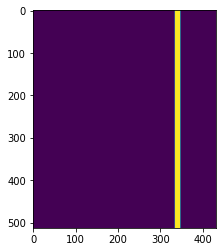

In [41]:
plt.imshow(mask[0])

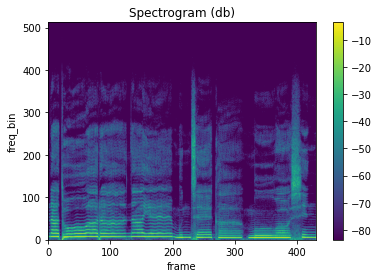

In [56]:
plot_spectrogram(spec[0]/10000)

In [83]:
test = amp_to_db(spec[0]/10000) * (1-mask[0])
test2 = amp_to_db(spec[0]/10000 * (1-mask[0]))

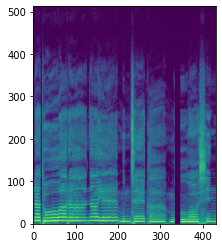

In [84]:
plt.imshow(test2, origin='lower')

In [81]:
np.where(mask[0]==1)

(array([  0,   0,   0, ..., 512, 512, 512]),
 array([334, 335, 336, ..., 344, 345, 346]))

In [67]:
amp_to_db = torchaudio.transforms.AmplitudeToDB(stype='power')

In [70]:
1-mask[0]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [85]:
test2[:,334]

tensor([-100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., 

In [88]:
spec.shape, mask.shape

(torch.Size([1, 513, 431]), torch.Size([1, 513, 431]))

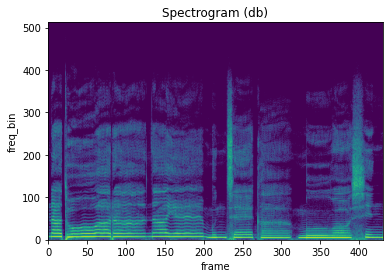

In [115]:
save_spectrogram(spec[0])

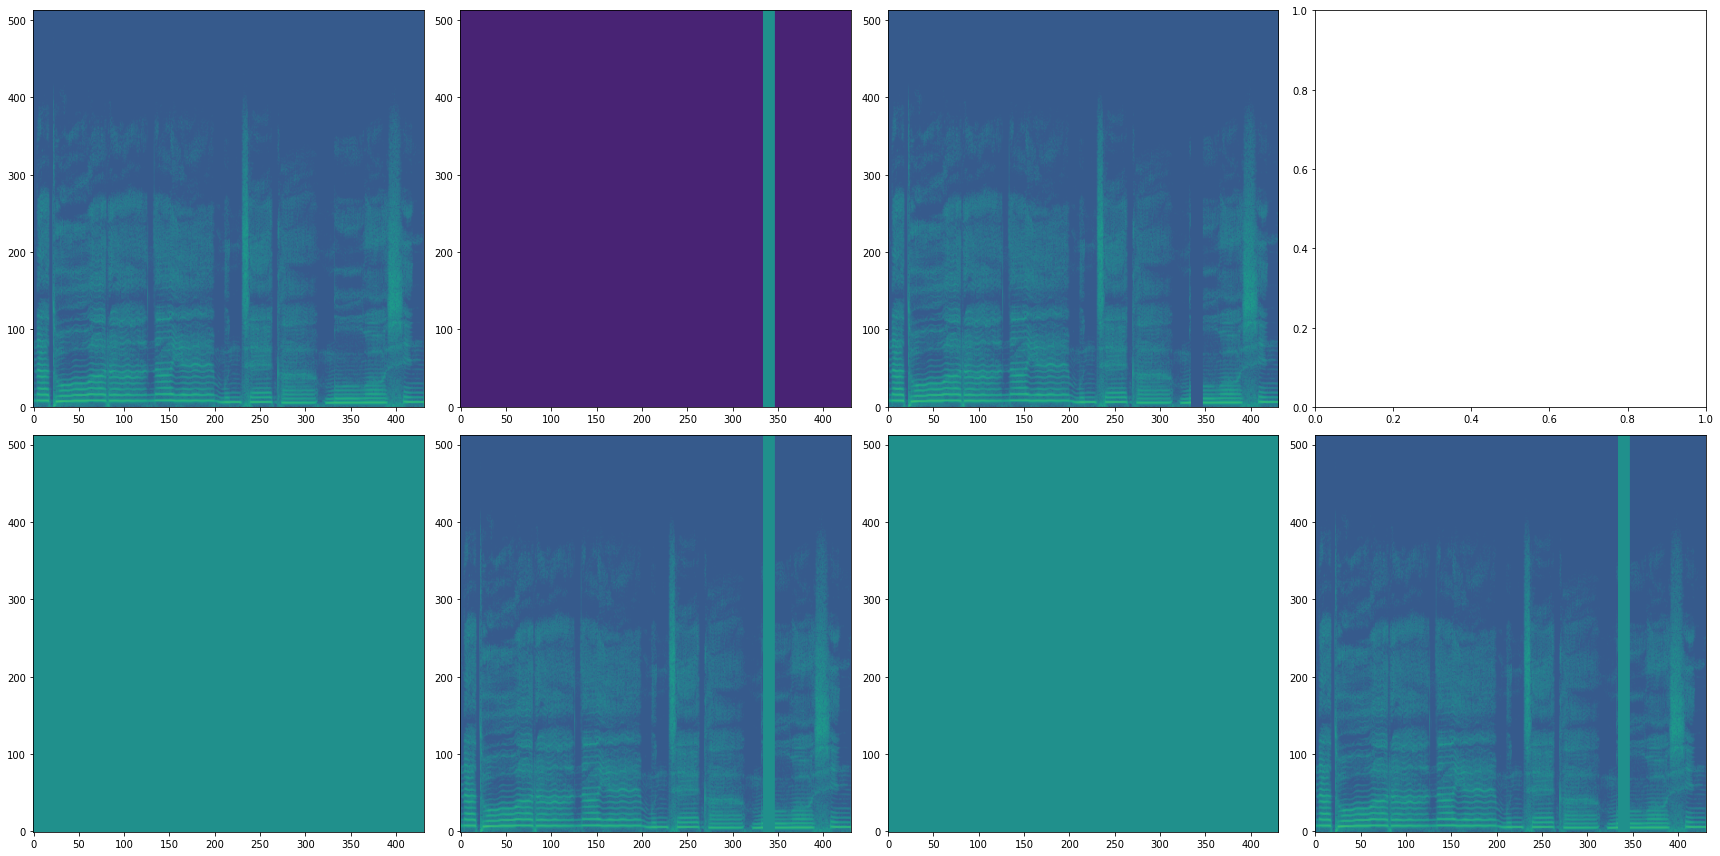

In [139]:
masked_img = spec * (1 - mask)
first = torch.ones([1, 513, 431])
firsted_img = spec * (1 - mask) + first * mask
fig, axes = plt.subplots(2, 4)
plot_spectrogram(spec[0], axes[0, 0])
plot_spectrogram(mask[0], axes[0, 1])
plot_spectrogram(masked_img[0], axes[0, 2])
plot_spectrogram(first[0], axes[1, 0])
plot_spectrogram(firsted_img[0], axes[1, 1])
plot_spectrogram(first[0], axes[1, 2])
plot_spectrogram(firsted_img[0], axes[1, 3])


fig.set_size_inches(24, 12)
fig.tight_layout()
plt.savefig('test.png')

In [140]:
mask.shape, spec.shape

(torch.Size([1, 513, 431]), torch.Size([1, 513, 431]))

In [127]:
axes.shape

(2, 4)

In [138]:
def plot_2spectrogram(x, ax):
  if type(x) == torch.Tensor:
    x = x.numpy()
  spec, freqs, t, m = ax.specgram(x, NFFT = 256, Fs = 48000, vmin = -160, vmax = 0)
  ax.set_yscale('symlog', linthreshy = 50)
  ax.set_ylim(60, sr / 2)
  ax.set_yticks([60, 120, 250, 500, 1000, 2000, 4000, 8000], minor = False)
  ax.set_yticks([], minor = True)
  ax.set_yticklabels(['60', '120', '250', '500', '1000', '2000', '4000', '8000'])
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequency (Hz)')
  return spec

def plot_spectrogram(spec, ax , title=None, ylabel='freq_bin', aspect='auto', xmax=None):
#   ax.set_title(title or 'Spectrogram (db)')
#   ax.set_ylabel(ylabel)
#   ax.set_xlabel('frame')
  im = ax.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect, vmin=-100, vmax=100)
  if xmax:
    ax.set_xlim((0, xmax))
  return im

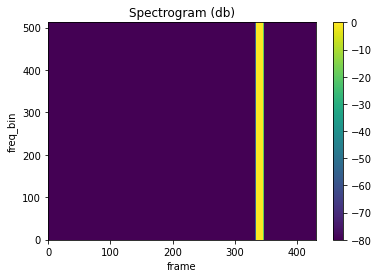

In [99]:
plot_spectrogram(mask[0])

In [100]:
spec.reshape(-1).shape

torch.Size([221103])

In [135]:
20*np.log(10000)

184.2068074395237